## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 28 columns):
EVENT_ID              8191 non-null int64
INJURIES_DIRECT       8191 non-null int64
DEATHS_DIRECT         8191 non-null int64
DAMAGE_PROPERTY       8191 non-null float64
DAMAGE_CROPS          8191 non-null float64
DURATION_SECONDS      8191 non-null float64
BEGIN_LAT             8191 non-null float64
BEGIN_LON             8191 non-null float64
TOR_LENGTH            8191 non-null float64
TOR_WIDTH             8191 non-null float64
BEGIN_DATE_TIME       8191 non-null float64
YEAR                  8191 non-null int64
CZ_NAME               8191 non-null object
OPEN_WATER_PROP       8191 non-null float64
DEV_OPEN_PROP         8191 non-null float64
DEV_LOW_PROP          8191 non-null float64
DEV_MED_PROP          8191 non-null float64
DEV_HIGH_PROP         8191 non-null float64
DECID_FOREST_PROP     8191 non-null float64
EVERGR_FOREST_PROP    8191 non-null float64
MIXED_FOREST_PROP     

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [3]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 1 columns):
DAMAGE_PROPERTY    8191 non-null float64
dtypes: float64(1)
memory usage: 64.1 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 5:]


# Get rid of non-location and non-landcover variables
tornado_features = tornado_features.drop(["YEAR",
                                          "CZ_NAME"],
                                         axis = 1)


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 21 columns):
DURATION_SECONDS      8191 non-null float64
BEGIN_LAT             8191 non-null float64
BEGIN_LON             8191 non-null float64
TOR_LENGTH            8191 non-null float64
TOR_WIDTH             8191 non-null float64
BEGIN_DATE_TIME       8191 non-null float64
OPEN_WATER_PROP       8191 non-null float64
DEV_OPEN_PROP         8191 non-null float64
DEV_LOW_PROP          8191 non-null float64
DEV_MED_PROP          8191 non-null float64
DEV_HIGH_PROP         8191 non-null float64
DECID_FOREST_PROP     8191 non-null float64
EVERGR_FOREST_PROP    8191 non-null float64
MIXED_FOREST_PROP     8191 non-null float64
SHRUB_SCRUB_PROP      8191 non-null float64
GRASS_LAND_PROP       8191 non-null float64
PASTURE_HAY_PROP      8191 non-null float64
CULT_CROPS_PROP       8191 non-null float64
WOOD_WETLAND_PROP     8191 non-null float64
HERB_WETLAND_PROP     8191 non-null float64
BARREN_LAND_P

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.3534
 0.9965
-1.1317
   ⋮    
 1.1563
-1.1317
-1.1317
[torch.DoubleTensor of size 8191x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 4.6236e-01 -3.3757e-01 -7.0216e-01  ...  -1.2423e+00  5.9959e-01 -6.9525e-01
 4.6236e-01  9.2274e-01 -6.6432e-01  ...   1.1258e+00 -2.1299e-01 -6.9525e-01
 4.6236e-01  4.7344e-01 -8.6840e-01  ...   2.9606e-02 -9.0635e-01 -6.9525e-01
                ...                   ⋱                   ...                
 3.4596e-01  7.9864e-01  2.0950e+00  ...   1.6329e-01  4.3847e-01 -6.9525e-01
 5.5754e-01  9.9777e-01 -1.4041e+00  ...  -1.2423e+00  2.4547e-01 -6.9525e-01
-3.7344e-01  7.1306e-01  3.8358e-01  ...  -1.2423e+00 -9.0635e-01 -6.9525e-01
[torch.DoubleTensor of size 8191x21]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 4.6236e-01 -3.3757e-01 -7.0216e-01  ...  -1.2423e+00  5.9959e-01 -6.9525e-01
 4.6236e-01  9.2274e-01 -6.6432e-01  ...   1.1258e+00 -2.1299e-01 -6.9525e-01
 4.6236e-01  4.7344e-01 -8.6840e-01  ...   2.9606e-02 -9.0635e-01 -6.9525e-01
                ...                   ⋱                   ...                
 3.4596e-01  7.9864e-01  2.0950e+00  ...   1.6329e-01  4.3847e-01 -6.9525e-01
 5.5754e-01  9.9777e-01 -1.4041e+00  ...  -1.2423e+00  2.4547e-01 -6.9525e-01
-3.7344e-01  7.1306e-01  3.8358e-01  ...  -1.2423e+00 -9.0635e-01 -6.9525e-01
[torch.FloatTensor of size 8191x21]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append the current summed error
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

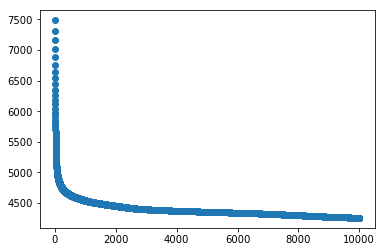

In [13]:
# Plot summer error as a function of iteration
plt.scatter(iterations, errors)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8191)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(8191)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

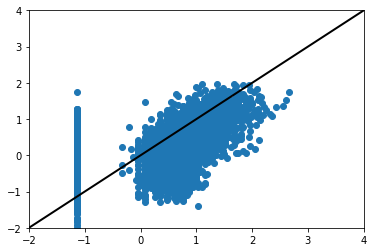

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [3]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)

In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 5:]

valid_predictors = valid_predictors.drop(["YEAR",
                                          "CZ_NAME"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)

In [19]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight

In [20]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 1913.0283
[torch.FloatTensor of size 1]

In [21]:
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 21 columns):
DURATION_SECONDS      2731 non-null float64
BEGIN_LAT             2731 non-null float64
BEGIN_LON             2731 non-null float64
TOR_LENGTH            2731 non-null float64
TOR_WIDTH             2731 non-null float64
BEGIN_DATE_TIME       2731 non-null float64
OPEN_WATER_PROP       2731 non-null float64
DEV_OPEN_PROP         2731 non-null float64
DEV_LOW_PROP          2731 non-null float64
DEV_MED_PROP          2731 non-null float64
DEV_HIGH_PROP         2731 non-null float64
DECID_FOREST_PROP     2731 non-null float64
EVERGR_FOREST_PROP    2731 non-null float64
MIXED_FOREST_PROP     2731 non-null float64
SHRUB_SCRUB_PROP      2731 non-null float64
GRASS_LAND_PROP       2731 non-null float64
PASTURE_HAY_PROP      2731 non-null float64
CULT_CROPS_PROP       2731 non-null float64
WOOD_WETLAND_PROP     2731 non-null float64
HERB_WETLAND_PROP     2731 non-null float64
BARREN_LAND_P

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2731)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [23]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(2731)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

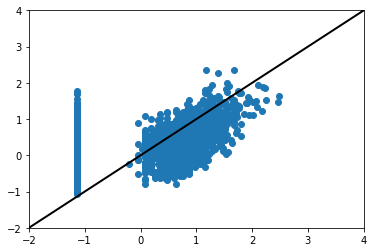

In [24]:
# Plot new predictions versus 'new' data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

## Round 2: Two-Hidden-Layer Neural Network

In [25]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [26]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 1))

In [27]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append the current summed error
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

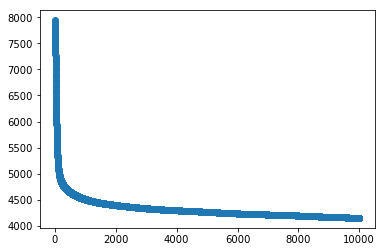

In [28]:
# Plot summer error as a function of iteration
plt.scatter(iterations, errors)

In [29]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8191)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

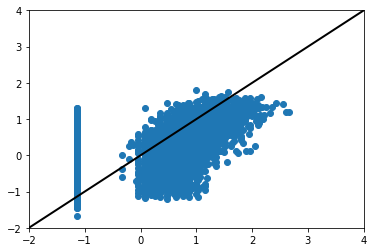

In [30]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [31]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight

In [32]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 2188.6702
[torch.FloatTensor of size 1]

In [33]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2731)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

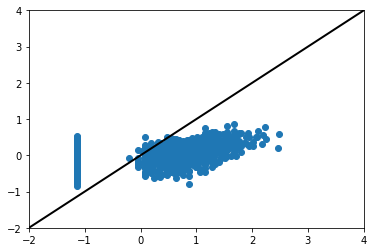

In [34]:
# Plot new predictions versus 'new' data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

## Round 3: Three-Hidden-Layer Neural Network

In [35]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [36]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [37]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append the current summed error
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

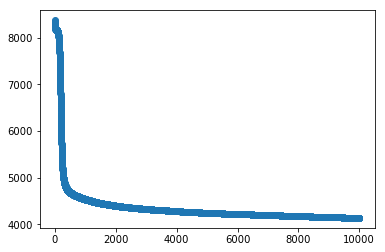

In [38]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [39]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8191)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

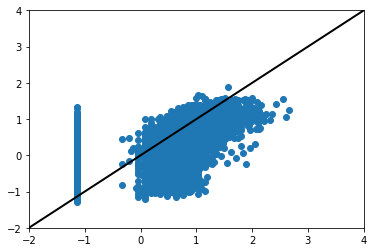

In [40]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [41]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 6),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(6, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight

In [42]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 2675.6816
[torch.FloatTensor of size 1]

In [43]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2731)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

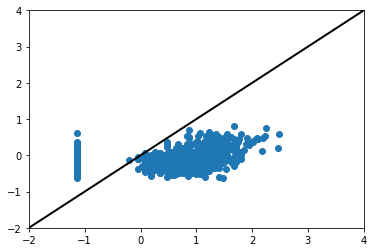

In [44]:
# Plot new predictions versus 'new' data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

## Round 4: Linear Regression

In [45]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [46]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(21, 1))

In [47]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append the current summed error
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

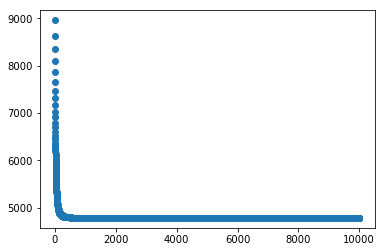

In [48]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [49]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8191)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

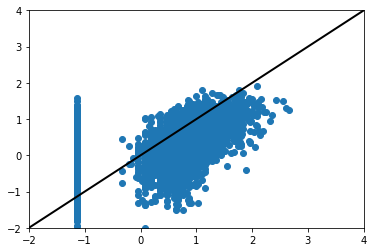

In [50]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [51]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight

In [52]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 1769.7013
[torch.FloatTensor of size 1]

In [53]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2731)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

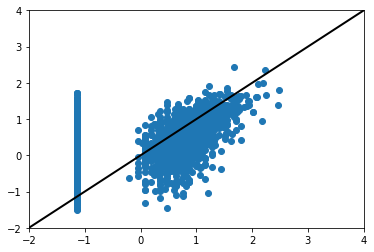

In [54]:
# Plot new predictions versus 'new' data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)